In [1]:
%load_ext autoreload
%autoreload 2 

%matplotlib inline

import torch
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
sns.set_context("notebook")

from sklearn import preprocessing
import pytorch_lightning as pl
from actpred.models import ActCNNSystem
from actpred.utils import get_threshold, get_stratified_split

from scipy.stats import spearmanr
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger, WandbLogger

In [2]:
pl.seed_everything(0)

Global seed set to 0


0

In [ ]:
# CHANGE TO POINT TO PATH ON YOUR COMPUTER!!!!
fn = "data/OrthologTilingDFwActivities_20220131.csv"
# df = pd.read_csv(fn, index_col=0)
# df = df.loc[df.Activity != 0.0]
# # average over duplicates
# df = df.groupby("Seq").mean().reset_index()



df = pd.read_csv(fn)
df = df.loc[df.Activity != 0.0]
df = df.iloc[:, 1:]
df = df.loc[df.loc[:, ['Seq', 'Activity']].drop_duplicates().index]


seqs = df.Seq.to_numpy()
activity = df.Activity.to_numpy()
thresh = 80_000
# get binary labels based on threshold
y_bin = (activity >= thresh).astype(np.int64).reshape(-1, 1)

# scale data to have mean 0 and variance 1
y_cont = activity.reshape(-1, 1)
scaler = preprocessing.StandardScaler().fit(y_cont)
y_cont = scaler.transform(y_cont)


# convert seqs to integer valued vectors
alphabet="ACDEFGHIKLMNPQRSTVWY"
aa_to_i = {aa:i for i, aa in enumerate(alphabet)}
i_to_aa = {i:aa for i, aa in enumerate(alphabet)}
X = np.asarray([[aa_to_i[aa] for aa in x] for x in seqs])

train, val, test = get_stratified_split(X, y_bin, y_cont, as_tensor=True)
(X_train, y_bin_train, y_cont_train) = train
(X_val, y_bin_val, y_cont_val) = val
(X_test, y_bin_test, y_cont_test) = test

In [4]:
# from sklearn.model_selection import StratifiedShuffleSplit

# def get_stratified_split(X,
#                          y_bin,
#                          y_cont,
#                          as_tensor=True,
#                          return_onehot=False):

#     splitter = StratifiedShuffleSplit(n_splits=1,
#                                       train_size=0.8,
#                                       random_state=0)
#     train_index, val_test_index = list(splitter.split(X, y_bin))[0]

#     X_train = X[train_index]
#     y_bin_train = y_bin[train_index]
#     y_cont_train = y_cont[train_index]

#     X_val_test = X[val_test_index]
#     y_bin_val_test = y_bin[val_test_index]
#     y_cont_val_test = y_cont[val_test_index]

#     splitter = StratifiedShuffleSplit(n_splits=1,
#                                       train_size=0.5,
#                                       random_state=0)
#     val_index, test_index = list(splitter.split(X_val_test, y_bin_val_test))[0]
#     X_val = X_val_test[val_index]
#     y_bin_val = y_bin_val_test[val_index]
#     y_cont_val = y_cont_val_test[val_index]

#     X_test = X_val_test[test_index]
#     y_bin_test = y_bin_val_test[test_index]
#     y_cont_test = y_cont_val_test[test_index]

#     if return_onehot:
#         enc = preprocessing.OneHotEncoder()
#         enc.fit(X)
#         X_train_one_hot, X_val_one_hot, X_test_one_hot = map(
#             enc.transform, (X_train, X_val, X_test))
#         # Convert to dense arrays
#         X_train_one_hot = X_train_one_hot.toarray()
#         X_val_one_hot = X_val_one_hot.toarray()
#         X_test_one_hot = X_test_one_hot.toarray()

#         if as_tensor:
#             X_train = torch.tensor(X_train)
#             X_train_one_hot = torch.tensor(X_train_one_hot)
#             y_bin_train = torch.tensor(y_bin_train)
#             y_cont_train = torch.tensor(y_cont_train)

#             X_val = torch.tensor(X_val)
#             X_val_one_hot = torch.tensor(X_val_one_hot)
#             y_bin_val = torch.tensor(y_bin_val)
#             y_cont_val = torch.tensor(y_cont_val)

#             X_test = torch.tensor(X_test)
#             X_test_one_hot = torch.tensor(X_test_one_hot)
#             y_bin_test = torch.tensor(y_bin_test)
#             y_cont_test = torch.tensor(y_cont_test)
#         return (X_train, X_train_one_hot, y_bin_train, y_cont_train), \
#             (X_val, X_val_one_hot, y_bin_val, y_cont_val), \
#             (X_test, X_test_one_hot, y_bin_test, y_cont_test)
#     else:
#         if as_tensor:
#             X_train = torch.tensor(X_train)
#             y_bin_train = torch.tensor(y_bin_train)
#             y_cont_train = torch.tensor(y_cont_train)

#             X_val = torch.tensor(X_val)
#             y_bin_val = torch.tensor(y_bin_val)
#             y_cont_val = torch.tensor(y_cont_val)

#             X_test = torch.tensor(X_test)
#             y_bin_test = torch.tensor(y_bin_test)
#             y_cont_test = torch.tensor(y_cont_test)
#         return (X_train, y_bin_train, y_cont_train), \
#             (X_val, y_bin_val, y_cont_val), \
#             (X_test, y_bin_test, y_cont_test)

# get_stratified_split(X, y_bin, y_cont, as_tensor=True, return_onehot=True)

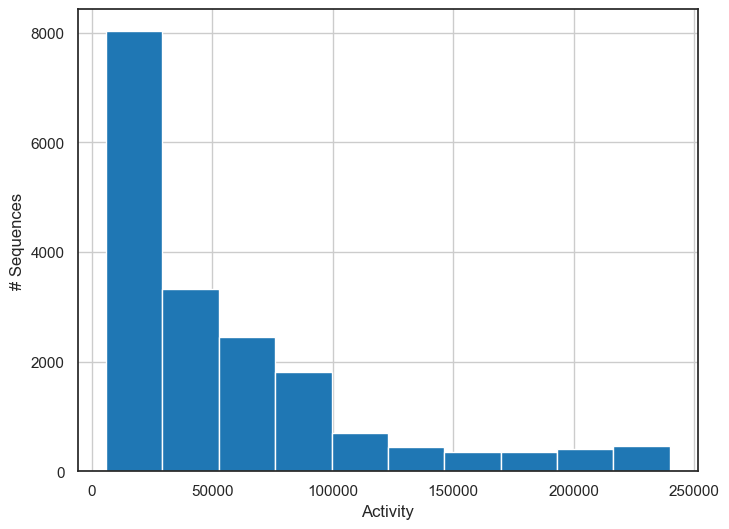

In [5]:
fig, ax = plt.subplots(figsize=(8,6))
df.Activity.hist(ax=ax)
ax.set(xlabel="Activity")
ax.set(ylabel="# Sequences")
sns.set_context('poster')

In [6]:
# Create Training and Validation Datasets
pl.seed_everything(0)

bs = 128
train_ds = TensorDataset(X_train, y_cont_train.to(torch.float))
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

val_ds = TensorDataset(X_val, y_cont_val.to(torch.float))
val_dl = DataLoader(val_ds, batch_size=bs)


Global seed set to 0


In [7]:
# Train Model
kernel_size = 5
dilation = 3 
hidden = 64


model = ActCNNSystem(hidden, kernel_size, dilation, num_res_blocks=3)
dirpath="models"
csv_logger = CSVLogger('logs')
checkpoint_callback = ModelCheckpoint(dirpath=dirpath, monitor="val_loss", filename="min_val_loss", save_last=True)
patience=10
early_stopping = EarlyStopping('val_loss', patience=patience)

trainer = pl.Trainer(accelerator="gpu", devices=1, callbacks=[checkpoint_callback, early_stopping], logger=[csv_logger], max_epochs=100)
trainer.fit(model, train_dataloaders=train_dl, val_dataloaders=val_dl)


/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.13/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.13/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory models exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | ActCNN           | 96.8 K
1 | loss_fn   | MSELoss          | 0     
2 | rmse      | MeanSquaredError | 0     
3 | pearsonr  | PearsonCorrCoef  | 0 

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  2.37it/s]val_rmse 1.4584070444107056
val_pearsonr 0.08345254510641098
val_spearmanr 0.09388377517461777
                                                                           

/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████| 130/130 [00:05<00:00, 22.79it/s, loss=0.5, v_num=10]  val_rmse 0.7064348459243774
val_pearsonr 0.7191029191017151
val_spearmanr 0.6484133005142212
Epoch 1: 100%|██████████| 130/130 [00:01<00:00, 75.64it/s, loss=0.432, v_num=10]val_rmse 0.6939398050308228
val_pearsonr 0.7391952872276306
val_spearmanr 0.6636813879013062
Epoch 2: 100%|██████████| 130/130 [00:01<00:00, 83.13it/s, loss=0.419, v_num=10]val_rmse 0.6923568844795227
val_pearsonr 0.7341858148574829
val_spearmanr 0.661558985710144
Epoch 3: 100%|██████████| 130/130 [00:01<00:00, 84.67it/s, loss=0.378, v_num=10]val_rmse 0.6856886744499207
val_pearsonr 0.741894543170929
val_spearmanr 0.6782399415969849
Epoch 4: 100%|██████████| 130/130 [00:01<00:00, 88.05it/s, loss=0.374, v_num=10]val_rmse 0.68031245470047
val_pearsonr 0.7505701780319214
val_spearmanr 0.6845216155052185
Epoch 5: 100%|██████████| 130/130 [00:01<00:00, 88.94it/s, loss=0.366, v_num=10]val_rmse 0.6718857884407043
val_pearsonr 0.7535343170166016

In [8]:
# get best model and save it
model = model.load_from_checkpoint(checkpoint_callback.best_model_path)
torch.save(model.cpu().state_dict(), "adhunter.pt")

In [21]:
# model("GGGGG")

In [9]:
# Load model 
model = ActCNNSystem(hidden, kernel_size, dilation, num_res_blocks=3)
model.load_state_dict(torch.load("adhunter.pt"))
# # put model on GPU, or ignore if you want to use CPU
# model.cuda()

<All keys matched successfully>

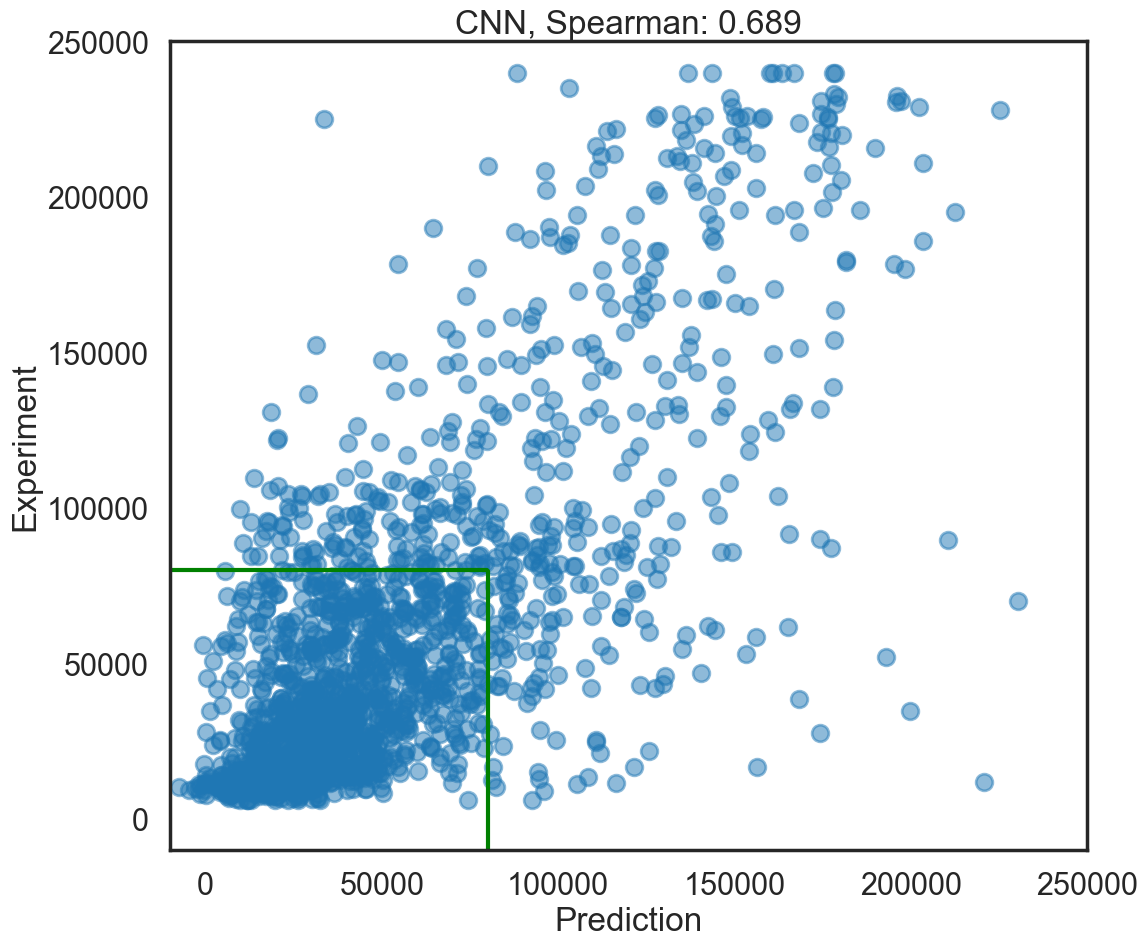

In [10]:
test_ds = TensorDataset(X_test, y_cont_test.to(torch.float))
test_dl = DataLoader(test_ds, batch_size=bs)

model.eval()
X_test, y_test = test_ds[:]
y_test = y_test.reshape(-1)
with torch.no_grad():
    y_test_hat = model(X_test).reshape(-1)
    y_test_hat = y_test_hat.detach().numpy()
    y_test = y_test.numpy()

best_thresh = get_threshold(y_bin_test, y_test_hat)
best_thresh_unscaled = scaler.inverse_transform(np.asarray([best_thresh]).reshape(-1, 1)).item()
y_test_hat_bin = (y_test_hat > best_thresh).astype(np.int32)

y_test_hat_unscaled = scaler.inverse_transform(y_test_hat.reshape(-1, 1)).reshape(-1)
y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(-1)

fig, ax = plt.subplots(figsize=(12,10))
ax.scatter(y_test_hat_unscaled, y_test_unscaled, alpha=0.5)
corr = spearmanr(y_test_hat_unscaled, y_test_unscaled).correlation
ax.set(xlabel="Prediction", ylabel="Experiment", title=f"CNN, Spearman: {corr:.3f}")
ax.set(xlim=(-10000, 250_000), ylim=(-10000, 250_000))
plt.tight_layout()
plt.axvline(x=80_000, c='green', ymax=0.345)
plt.axhline(y=80_000, c='green', xmax=0.345)

# Attempting to save the model as ONNX
This didn't end up working, but looks like captum supports DeepLIFT natively in PyTorch, so this may be unnecessary. Keeping it for now in case I need it later.

In [11]:
sample_input = torch.randint(0, 20, (1, 40))
onnx_filename = "actcnn_model.onnx"
torch.onnx.export(
    model,
    sample_input,
    onnx_filename,
    export_params=True,
    # opset_version=11,  # Use ONNX opset version 11
    do_constant_folding=True,
    input_names=['input'],
    output_names=['output'],
    dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}
)

In [12]:
model(sample_input)

tensor([0.5306], grad_fn=<ViewBackward0>)

In [13]:
import onnxruntime
sess = onnxruntime.InferenceSession(onnx_filename)
input_tensor = sample_input.numpy()
input_name = sess.get_inputs()[0].name
output_name = sess.get_outputs()[0].name
onnx_output = sess.run([output_name], {input_name: input_tensor})
print("Inference result from ONNX model:", onnx_output)


2025-02-28 11:04:25.826641 [E:onnxruntime:, sequential_executor.cc:516 ExecuteKernel] Non-zero status code returned while running FusedConv node. Name:'/model/res_blocks.0/conv_res/Conv' Status Message: Dilation not supported for AutoPadType::SAME_UPPER or AutoPadType::SAME_LOWER.


InvalidArgument: [ONNXRuntimeError] : 2 : INVALID_ARGUMENT : Non-zero status code returned while running FusedConv node. Name:'/model/res_blocks.0/conv_res/Conv' Status Message: Dilation not supported for AutoPadType::SAME_UPPER or AutoPadType::SAME_LOWER.